# Training the sunspot paramentrization model

In this notebook we will train a combination of VAE and PCA models to obtain a latent representation  of sunspot group images.

Required imports

In [1]:
import sys
sys.path.append('..')
import numpy as np
import pandas as pd
import torch
import torch.optim as optim
import torchvision.models as models
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from tqdm import tqdm
import pickle as pk

from helio.helio import FilesIndex, HelioBatch, BatchSampler
from helio.helio.models import VAE

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Training the VAE model

For sunspot parametrization we will use the Variational Autoencoder model. Below we define its architecture. It is assumed that the input image has one channel (`in_channels`). Input image goes through a sequence of convolution layers with the number of filters increasing according to `filters_enc`. The parameter `z_dim` defines the number of channels in the latent space. Latent tensor is decoded 
through a sequence of convolutions with the number of filters decreasing according to `filters_dec`. Configuration of the output layer is defined in `output` and contains a single convolutional layer with the number of filters equal to 1. See `helio.models.torch_models` for more details of implementation.

In [2]:
net = VAE(in_channels=1,
    filters_enc=[16, 24, 32, 64],
    filters_dec=[48, 32, 24, 16],
    z_dim=16,
    output=dict(layout='c', filters=1),
    norm=True,
    variational=True).to(device)

For the perception loss we will also need the pre-trained VGG11 model. One can get it as follows

In [3]:
vgg = models.vgg11(pretrained=True)

We truncate the VGG11 model to get an access to its feature tensor:

In [4]:
dis = vgg.features.to(device)

Following the recommendations to the VGG11 model, we define the vectors of mean and variance:

In [5]:
vgg_mean = torch.tensor([0.485, 0.456, 0.406]).view(1, 3, 1, 1).to(device)
vgg_std = torch.tensor([0.229, 0.224, 0.225]).view(1, 3, 1, 1).to(device)

Next we index files in the dataset of sunspot group images:

In [6]:
index = FilesIndex(img='../dataset/sunspot_dataset/*.npz').sort_index()
index.head()

,img
FilesIndex,
201007230452_63,../dataset/sunspot_dataset/201007230452_63.npz
201007240414_63,../dataset/sunspot_dataset/201007240414_63.npz
201007250447_63,../dataset/sunspot_dataset/201007250447_63.npz
201007250447_64,../dataset/sunspot_dataset/201007250447_64.npz
201007260349_63,../dataset/sunspot_dataset/201007260349_63.npz


Split the dataset into training and test subsets:

In [7]:
itrain, itest = index.train_test_split(train_ratio=0.8, shuffle=True, seed=1234)

Set up an optimizer:

In [8]:
optimizer_ae = optim.Adam(net.parameters(), lr=0.001)

Define a function measuring Kullback-Leibler divergence:

In [9]:
def loss_kl(mu, logvar):
    return -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())

Define a batch sampler. It will gerenrate random batches of size 32 from the training subset:

In [10]:
sampler = BatchSampler(itrain, n_epochs=150, batch_size=32,
                       shuffle=True, drop_incomplete=True)

Define a function that will convert 3-channel binary masks to 1-channel images

In [11]:
def transform_channels(arr):
    out = (arr[..., 0] | arr[..., 2]).astype(np.float32)
    out[arr[..., 1]] = 2
    return np.expand_dims(out, 0) / 2 #normalize to [0, 1]

Let's look at a sample sunspot group from the dataset. Below we load a single sunspot group, transform it to the 1-channel format and plot the image:

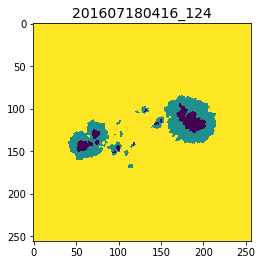

In [12]:
batch = (HelioBatch(index.loc[['201607180416_124']])
             .load('img', sparse=True)
             .apply(lambda x: x.toarray().reshape(256, 256, 3), src='img')
             .apply(transform_channels, src='img'))
plt.imshow(1-np.squeeze(batch.img[0]))
plt.title(batch.indices[0], fontsize=14)
plt.show()

We are ready to run the model training pipeline. In contains several steps:
* load a batch of data
* transform to 1-channel format
* transform to torch tensors
* obtain latent tensors μ and σ and output of the VAE model
* compute the reconstruction loss (loss1)
* compute the perceptual loss (loss2)
* compute the Kullback-Leibler loss (loss3)
* final loss is 100*loss1 + loss2 + loss3 (we use weight 100 to equalize scales)
* optimization step

In [13]:
net = net.train()
dis = dis.eval()

loss_hist = []
t = tqdm(sampler)

for ids in t:
    #Load data
    batch = (HelioBatch(ids)
             .load('img', sparse=True)
             .apply(lambda x: x.toarray().reshape(256, 256, 3), src='img')
             .apply(transform_channels, src='img'))
    
    #Convert arrays to torch tensors
    x = torch.tensor(np.stack(batch.img)).to(device)

    #Run the VAE model
    out, mu, logvar = net(x)

    #Reconstruction loss (pixel-wise MSE)
    loss1 = ((x - out)**2).mean()
    
    #Data preparation for the perceptual loss
    x3 = torch.cat([x, x, x], dim=1)
    out3 = torch.cat([out, out, out], dim=1)

    fx = dis((x3 - vgg_mean) / vgg_std)
    fout = dis((out3 - vgg_mean) / vgg_std)

    #Perceptual loss
    loss2 = ((fx - fout)**2).mean() 

    #Kullback-Leibler loss
    loss3 = loss_kl(mu, logvar)
    
    #Final loss
    loss = 100*loss1 + loss2 + loss3

    loss_hist.append([loss1.item(), loss2.item(), loss3.item()])
    t.set_description("Loss rec {:.4f} dis {:.4f} kl {:.4f}"
                      .format(loss1.item(), loss2.item(), loss3.item()))

    #Make optimization step
    optimizer_ae.zero_grad()
    loss.backward()
    optimizer_ae.step()

Loss rec 0.0006 dis 0.0368 kl 0.0280: 100%|██████████| 31800/31800 [3:53:56<00:00,  2.27it/s]


Loss decay plots for each component of the final loss. Blue line shows loss value at each iteration, orange line shows averaged loss over 100 iterations:

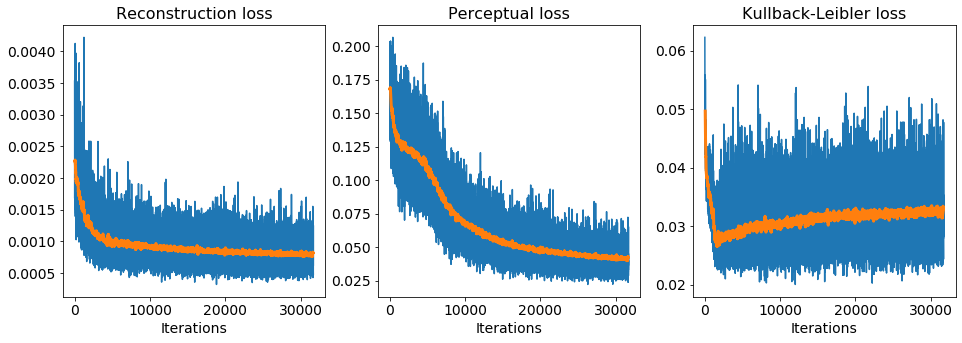

In [14]:
skip = 100
fig, ax = plt.subplots(1, 3, figsize=(16, 5))
fig.patch.set_facecolor('xkcd:white')
loss = np.asarray(loss_hist)
for i in range(3):
    ax[i].plot(loss[skip:, i])
    ax[i].plot(pd.DataFrame(loss[skip:, i]).rolling(100, center=True).mean(), lw=3)
    ax[i].set_xlabel('Iterations', fontsize=14)
    ax[i].tick_params(axis='both', which='major', labelsize=14)
ax[0].set_title('Reconstruction loss', fontsize=16)
ax[1].set_title('Perceptual loss', fontsize=16)
ax[2].set_title('Kullback-Leibler loss', fontsize=16)
plt.show()

Dump the model:

In [15]:
torch.save(net.state_dict(), 'model_dumps/vae')

## Training the PCA model

Below we apply the PCA model to the latent vectors obtained with the VAE model.
First, we obtain the latent vectors with the VAE encoder:

In [16]:
emb = [] #array of latent vectors
sampler = BatchSampler(itrain, n_epochs=1, batch_size=64,
                       shuffle=False, drop_incomplete=False)

net = net.eval()
with torch.no_grad():
    for ids in sampler:
        batch = (HelioBatch(ids)
                 .load('img', sparse=True)
                 .apply(lambda x: x.toarray().reshape(256, 256, 3), src='img')
                 .apply(transform_channels, src='img'))
        x = torch.tensor(np.stack(batch.img)).to(device)
        y = net.encode(x)
        emb.append(y.detach().cpu().numpy().reshape(y.shape[0], -1))
emb = np.vstack(emb)  

Now we can fit the PCA model and transform the latent vectors:

In [17]:
pca = PCA(0.95)
reduced = pca.fit_transform(emb)

Compare the dimensionality of initial and transformed latent vectors:

In [18]:
print('Initial latent size (VAE):', emb.shape[1])
print('Reduced latent size (VAE+PCA):', reduced.shape[1])

Initial latent size (VAE): 4096
Reduced latent size (VAE+PCA): 254


Note that the number of principal components can fluctuate near 285 presented in the paper. The reason is in stochastics initialization of the VAE model and stochastics optimization procedure. However, these minor variations do not affect interpretation of leading principal components and global structure of the latent space.

Now consider test samples. Here we encode test images with the VAE encoder, apply the PCA transformation, then apply the inverse PCA transformation and decode with the VAE decoder:

In [19]:
net = net.eval()

with torch.no_grad():
    batch = (HelioBatch(itest.iloc[:100])
             .load('img', sparse=True)
             .apply(lambda x: x.toarray().reshape(256, 256, 3), src='img')
             .apply(transform_channels, src='img'))
    x = torch.tensor(np.stack(batch.img)).to(device)
    y, mu, _ = net(x)
    rmu = pca.transform(mu.detach().cpu().numpy().reshape(x.shape[0], -1))
    irmu = pca.inverse_transform(rmu).reshape(mu.shape)
    x2 = torch.tensor(irmu).to(device).float()
    y2 = net.decode(x2)

Plot samples from the test subset and results of encoding-decoding with VAE and VAE+PCA models:

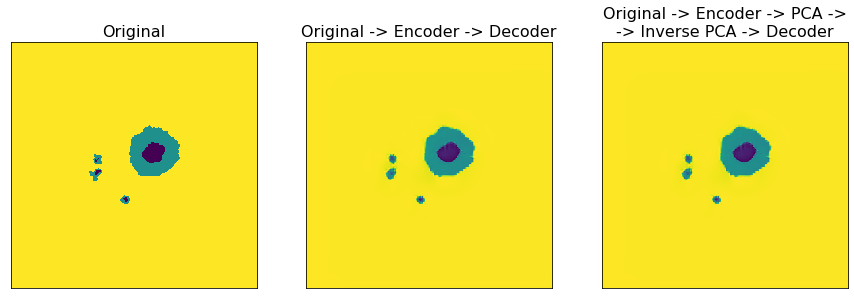

In [20]:
i = 75
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
fig.patch.set_facecolor('xkcd:white')
ax[0].imshow(1-x[i, 0].detach().cpu().numpy(), vmin=0, vmax=1)
ax[1].imshow(1-y[i, 0].detach().cpu().numpy(), vmin=0, vmax=1)
ax[2].imshow(1-y2[i, 0].detach().cpu().numpy(), vmin=0, vmax=1)
ax[0].set_title('Original', fontsize=16)
ax[1].set_title('Original -> Encoder -> Decoder', fontsize=16)
ax[2].set_title('Original -> Encoder -> PCA ->\n-> Inverse PCA -> Decoder', fontsize=16)
for a in ax:
    a.set_xticks([])
    a.set_yticks([])
plt.show()

Dump the PCA model:

In [21]:
pk.dump(pca, open("model_dumps/pca.pkl",'wb'))

Done! In the next notebook `Latent_space_exploration.ipynb` we will investigate the latent space.